In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PCA as pca
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve
import emcee
import corner
%matplotlib inline

In [2]:
from modeling import Model
class SimpleKernel(Model):
    parameter_names = ("log_b", )
    
    def get_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return a * np.exp(-b * tau**2)
    
    def get_grad_1_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * tau * np.exp(-b * tau**2)
    
    def get_grad_2_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * np.exp(-b * tau**2) * (1.0 - 2 * b * tau**2)
    
class RVKernel(Model):
    parameter_names = ("vc", "vr", "lc", "lr", "bc", "br")
    
    def __init__(self, G, *args, **kwargs):
        self.G = G
        super(RVKernel, self).__init__(*args, **kwargs)
    
    def get_value(self, tau, l1, l2):
#         vc = np.exp(self.log_vc)
#         vr = np.exp(self.log_vr)
#         lc = np.exp(self.log_lc)
#         bc = np.exp(self.log_bc)
#         br = np.exp(self.log_br)
        vc = self.vc
        vr = self.vr
        lc = self.lc
        lr = self.lr
        bc = self.bc
        br = self.br
        
        # Compute the value of gamma and its derivatives
        g = self.G.get_value(tau)
        gp1 = self.G.get_grad_1_value(tau)
        gp2 = self.G.get_grad_1_value(-tau)
        gpp = self.G.get_grad_2_value(tau)
        
        # We'll use these masks to build the blocked kernel matrix
        m11 = l1 == 1
        m12 = l1 == 2
        m13 = l1 == 3
        m21 = l2 == 1
        m22 = l2 == 2
        m23 = l2 == 3
        
        # Allocate the matrix and loop over blocks
        K = np.zeros_like(tau)
        zero_tau = np.isclose(tau, 0.0)
        
        # k11
        m = m11 * m21
        K[m] = vc**2*g[m] + vr**2*gpp[m] + vr*vc*(gp1 + gp2)[m]
        m &= zero_tau

        # k22
        m = m12 * m22
        K[m] = lc**2*g[m] + lr**2*gpp[m] + lr*lc*(gp1 + gp2)[m]
        m &= zero_tau

        # k33
        m = m13 * m23
        K[m] = bc**2*g[m] + br**2*gpp[m] + bc*br*(gp1 + gp2)[m]
        m &= zero_tau

        # k12
        m = m11 * m22
        K[m] = vc*lc*g[m] + vr*lr*gpp[m] + vc*lr*gp1[m] + vr*lc*gp2[m]
        m = m12 * m21
        K[m] = vc*lc*g[m] + vr*lr*gpp[m] + vc*lr*gp2[m] + vr*lc*gp1[m]
#         m = m11 * m22
#         K[m] = vc*lc*g[m] + vr*lc*gp2[m]
#         m = m12 * m21
#         K[m] = vc*lc*g[m] + vr*lc*gp1[m]

        # k13
        m = m11 * m23
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp1[m] + vr*bc*gp2[m]
        m = m13 * m21
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp2[m] + vr*bc*gp1[m]

        # k23
        m = m12 * m23
        K[m] = lc*bc*g[m] + lr*br*gpp[m] + lc*br*gp1[m] + lr*bc*gp2[m]
        m = m13 * m22
        K[m] = lc*bc*g[m] + lr*br*gpp[m] + lc*br*gp2[m] + lr*bc*gp1[m]
#         m = m12 * m23
#         K[m] = lc*bc*g[m] + lc*br*gp1[m]
#         m = m13 * m22
#         K[m] = lc*bc*g[m] + lc*br*gp2[m]

        return K

In [3]:
# Get PCA of simulated spectra
dir_ = "simulated_spectra/"   # data directory
pcs = 3                       # number of pca components
WL = (3924, 6662)             # single range

x, v, z_raw, xs_hat, x_hat, wavelengths, ev = pca.do_PCA(dir_, WL, pcs, 1)
phases_raw = np.load('files/phases.npy')

Successfully loaded files
3 PCs explain 0.997743 of the variance for wavelimits:. (3924, 6662)


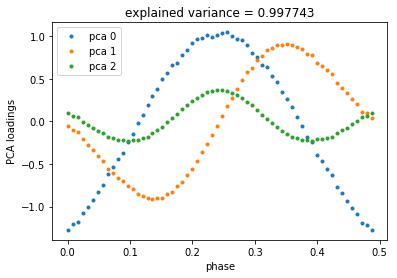

In [4]:
def prep_data(phases, z, rescale_fac, l1=-np.inf, l2=np.inf, re_center=1):
    index = (phases > l1) & (phases < l2)
    
    phases = phases[index]
    phases -= np.min(phases)
    z = z[index]
    z = z/rescale_fac
    
    if re_center == 1: # after removing baseline points, GP requires 0 mean
        for i in range(z.shape[1]):
            z[:,i] -= np.mean(z[:,i])
    return phases, z

phases, z = prep_data(phases_raw, z_raw, 500, -0.25, 0.25)

for i in range(pcs):
    plt.plot(phases, z[:,i], '.', label='pca %d'%i)
plt.ylabel('PCA loadings')
plt.xlabel('phase')
plt.title('explained variance = %f'%ev)
plt.legend()

In [5]:
# Prepare Data
n = len(z)

# indices
l = np.zeros(0)
p = np.zeros(0)
y = np.zeros(0)
for i in range(pcs):
    l = np.concatenate((l, np.ones(n)*(i+1)))
    p = np.concatenate((p, phases))
    y = np.concatenate((y, z[:, i]))

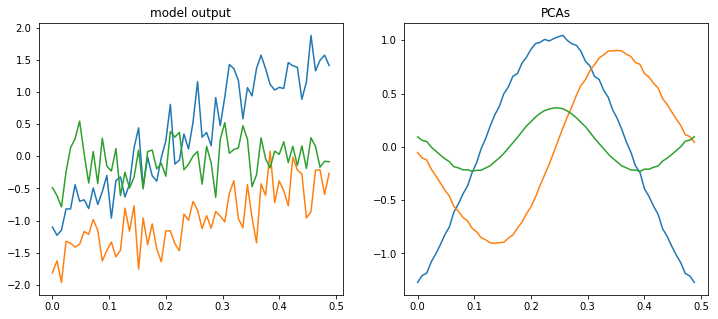

In [35]:
# initial conditions/priors setting
func = SimpleKernel(0.1)
kernel = RVKernel(func, 0.1, 1.0, 1.6, 0.3, 0.2, 0.1)

K = kernel.get_value(p[:, None] - p[None, :], l[:, None], l[None, :])
K[np.diag_indices(len(p))] += 0.1
y_temp = np.random.multivariate_normal(np.zeros_like(p), K)

f, (ax1, ax2) = plt.subplots(1,2, figsize=[12,5])
for i in [1, 2, 3]:
    ax1.plot(p[l==i], y_temp[l==i])
    ax2.plot(p[l==i], y[l==i])
    ax1.set_title('model output')
    ax2.set_title('PCAs')

In [25]:
def log_prior(params):
    logL, logvc, logvr, loglc, loglr, logbc, logbr = params
    #if -10<vc<10 and -10<vr<10 and -10<lc<10 and -10<lr<10 and -10<bc<10 and -10<br<10:
    if -5<logL<1 and -3<logvc<1 and -3<logvr<1 and -3<loglc<1 and -3<loglr<1 and -3<logbc<1 and -3<logbr<1:
        return 0   
    return -np.inf 

def log_prob(params, y, p, l):
    lnp = log_prior(params)
    if not np.isfinite(lnp):
        return -np.inf
    n = func.vector_size
    func.set_parameter_vector(10**params[:n])
    kernel.set_parameter_vector(10**params[n:])
    K = kernel.get_value(p[:, None] - p[None, :], l[:, None], l[None, :])
    K[np.diag_indices_from(K)] += 0.1
    try:
        L = cho_factor(K, overwrite_a=True)
    except (np.linalg.LinAlgError, ValueError):
        return -np.inf
    logdet = 2.0 * np.sum(np.log(np.diag(L[0])))
    ll = -0.5 * (np.dot(y, cho_solve(L, y)) + logdet)
    if not np.isfinite(ll):
        return -np.inf
    return ll

In [19]:
# set up sampler
nwalkers, ndim, nsteps = 50, func.vector_size + kernel.vector_size, 1000
p0 = np.log10(np.append(func.get_parameter_vector(), kernel.get_parameter_vector()))  #try log10 space
p0 = 1e-4*np.random.randn(nwalkers, len(p0))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(y, p, l))

In [21]:
# Run!
for i, (pos, lnp, state) in enumerate(sampler.sample(p0, iterations=nsteps)):
    if (i+1) % (nsteps/10) == 0:
        print("{0:.1f}%".format(100 * float(i) / nsteps), end=", ")
np.save("emcee_chain_log10.npy", sampler.chain)

9.9%, 19.9%, 29.9%, 39.9%, 49.9%, 59.9%, 69.9%, 79.9%, 89.9%, 99.9%, 

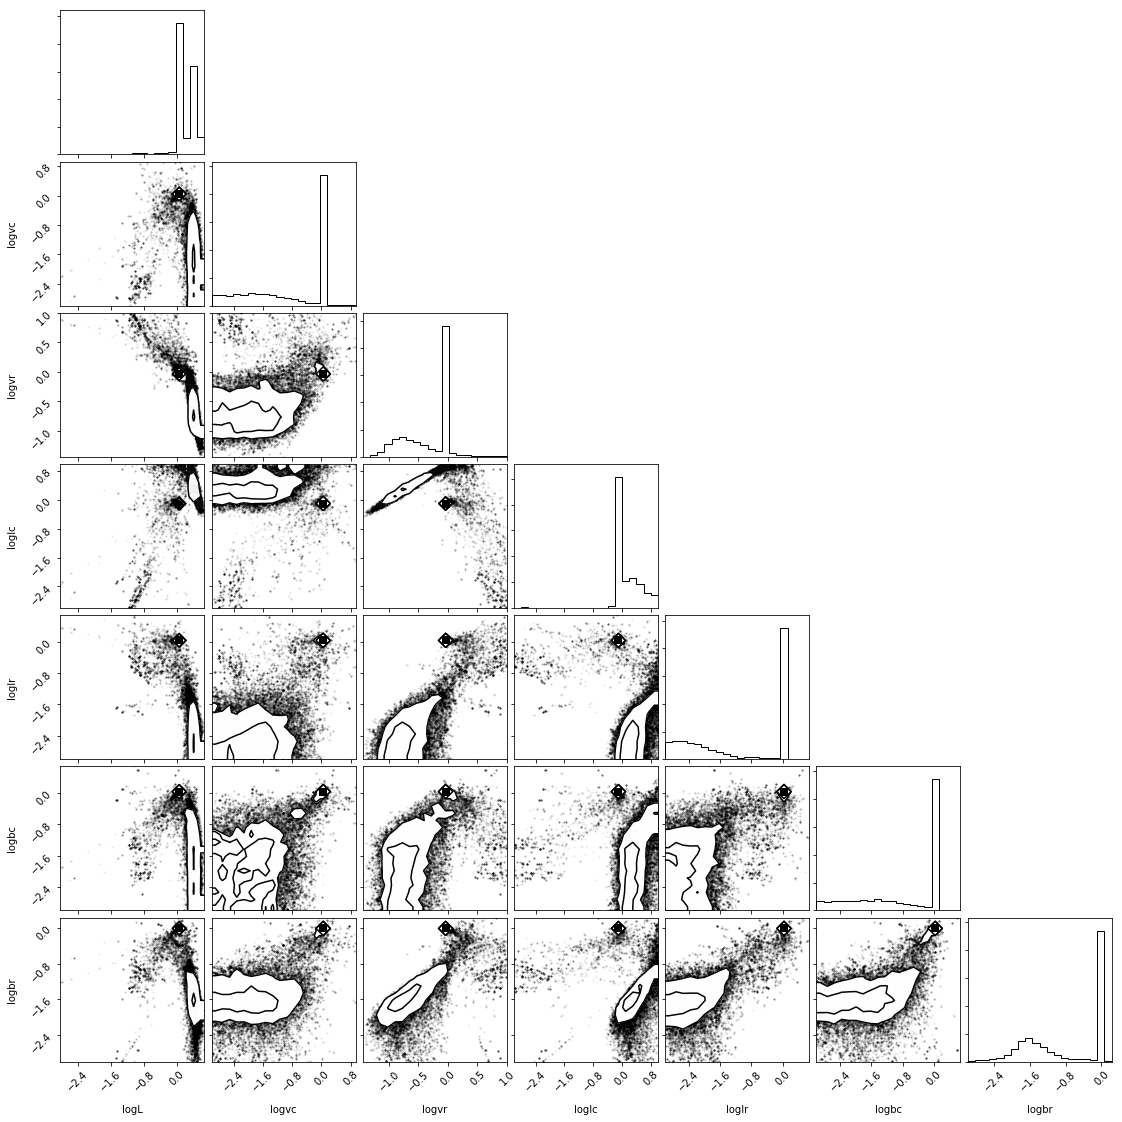

In [22]:
try:
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
except:
    samples = np.load("emcee_chain_log10.npy")[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["logL", "logvc", "logvr", "loglc", "loglr","logbc", "logbr"])
plt.savefig("images/corner_log10.png")

(600,)


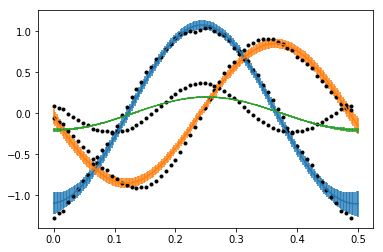

In [90]:
params = samples[-1]
n = func.vector_size
func.set_parameter_vector(10**params[:n])
kernel.set_parameter_vector(10**params[n:])

x = np.linspace(0, 0.5, 200)
# test points
xl = np.zeros(0)
xp = np.zeros(0)
for i in range(pcs):
    xp = np.concatenate((xp, x))
    xl = np.concatenate((xl, np.ones(len(x))*(i+1)))

K = kernel.get_value(p[:, None] - p[None, :], l[:, None], l[None, :])
Ks = kernel.get_value(xp[:, None] - p[None, :], xl[:, None], l[None, :])
Kx = kernel.get_value(xp[:, None] - xp[None, :], xl[:, None], xl[None, :]) 
K[np.diag_indices(len(p))] += 0.1

# mu = np.linalg.inv(C).dot(B.T).T.dot(y)
# sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
mu = np.dot(Ks, np.linalg.solve(K, y))
sigma_cov = Kx - np.dot(Ks, np.linalg.solve(K, Ks.T)) #covariance matrix for predictions
sigma = np.sqrt(np.diag(sigma_cov))

for i in range(3):
    pl = plt.plot(p[l==i+1], y[l==i+1], "k.");
    plt.errorbar(xp[xl==i+1], mu[xl==i+1], yerr=sigma[xl==i+1])

plt.savefig("images/emcee_fit.png")